# Imports

In [10]:
import pandas as pd
import numpy as np
from io import StringIO
import os
import requests
import pip
import matplotlib.pyplot as plt


In [11]:
outpath = "Figures"

# Reading tabulars to dataframes and Preparing a table for lowering down the EDAM operations

In [12]:
tools_db = pd.read_table('tools.tsv')
tools2_db = tools_db[tools_db['To keep']==True]
tools3_db =tools2_db[tools2_db['EDAM operation'].notna()]
tmp = pd.concat( [tools3_db['Galaxy tool ids'], tools3_db['EDAM operation'].str.split(',', expand=True).add_prefix('SubColumn')], axis=1 )
#tmp.set_index('Galaxy tool ids', inplace=True)
#tools2_db.head()
#print(tools3_db)

tmp.head()

,Galaxy tool ids,SubColumn0,SubColumn1,SubColumn2,SubColumn3,SubColumn4,SubColumn5,SubColumn6,SubColumn7,SubColumn8,...,SubColumn10,SubColumn11,SubColumn12,SubColumn13,SubColumn14,SubColumn15,SubColumn16,SubColumn17,SubColumn18,SubColumn19
12,lotus2,Sequence feature detection,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
119,antismash,Sequence clustering,Gene prediction,Differential gene expression analysis,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
129,combine_metaphlan_humann,Aggregation,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
130,compare_humann2_output,Comparison,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
133,format_metaphlan2_output,Formatting,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Using OWL aginst the tmp tabular to keep only the leaf node of the same branch for EDAM operations of one tool that belong to the same branch

In [13]:
import pandas as pd
from owlready2 import get_ontology, Thing
import copy

def process_row(row):
# Remove extra spaces from each column value in the row
    cleaned_row = [str(value).strip() for value in row[1:]]  # Exclude the first column ('Galaxy tool ids')
    
    # Convert the cleaned row to a list of EDAM terms using the provided ontology
    edam_ontology = get_ontology('https://edamontology.org/EDAM_1.25.owl').load()
    
    terms = cleaned_row
    classes = [edam_ontology.search_one(label=term) for term in terms]
    check_classes = [cla for cla in classes if cla is not None]  # Remove None values
    
    new_classes = []
    for cla in check_classes:
        try:
            # get all subclasses
            subclasses = list(cla.subclasses())
    
            # check if any of the other classes is a subclass
            include_class = True
            for subcla in subclasses:
                for cla2 in check_classes:
                    if subcla == cla2:
                        include_class = False
    
            # only keep the class if it is not a parent class
            if include_class:
                new_classes.append(cla)
        except Exception as e:
            print(f"Error processing class {cla}: {e}")

    # convert back to terms, skipping None values
    new_terms = [cla.label[0] for cla in new_classes if cla is not None]
    
    # Include the first column ('Galaxy tool ids') in the returned series
    return pd.Series([row[0], ', '.join(new_terms)])  # Combine the new terms with commas

def process_dataframe(input_df):
    # Apply the process_row function to each row in the dataframe
    output_df = input_df.apply(process_row, axis=1)
    
    # Set the header of the output dataframe
    output_df.columns = ['Galaxy tool ids', 'EDAM operation']
    
    return output_df

example_df = pd.DataFrame({
    'Galaxy tool ids': ['tool1', 'tool2', 'tool3'],
    'SubColumn0': ['Differential protein expression profiling', 'Sequence analysis', 'Data retrieval'],
    'SubColumn1': [' Gene expression profiling ', '  Phylogenetic tree analysis  ', ' Service invocation ']
})


processed_df = process_dataframe(tmp)
processed_df.to_csv('filteredtoolsEDAMoperations.csv', index=False)



## Updating EDAM Operation column in the original tool.tsv file and save it to updatedtools.tsv

In [14]:
if 'EDAM operation' in tools2_db.columns and 'EDAM operation' in processed_df.columns:
    # Add the column from df2 to df1 with a new name
    tools2_db['EDAM operation low classes'] = tools2_db['EDAM operation']
else:
    print("Column 'EDAM operation' not found in one or both dataframes.")

tools2_db.to_csv('Updatedtools.tsv', index=False)

tools2_db.head()

/tmp/ipykernel_24265/1080805737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tools2_db['EDAM operation low classes'] = tools2_db['EDAM operation']


,Galaxy wrapper id,Total tool usage (usegalaxy.eu),No. of tool users (2022-2023) (usegalaxy.eu),Galaxy tool ids,Description,bio.tool id,bio.tool name,bio.tool description,EDAM operation,EDAM topic,...,Galaxy wrapper source,Galaxy wrapper version,Conda id,Conda version,https://usegalaxy.org,https://usegalaxy.org.au,https://usegalaxy.eu,Reviewed,To keep,EDAM operation low classes
6,TreeBest,NaN,NaN,treebest_best,TreeBeST best,NaN,NaN,NaN,NaN,NaN,...,https://github.com/TGAC/earlham-galaxytools/tr...,1.9.2.post0,treebest,1.9.2.post1,(0/1),(0/1),(1/1),True,True,NaN
8,ete,1255.0,67.0,"ete_gene_csv_finder, ete_genetree_splitter, et...",Analyse phylogenetic trees using the ETE Toolkit,NaN,NaN,NaN,NaN,NaN,...,https://github.com/TGAC/earlham-galaxytools/tr...,3.1.2,ete3,3.1.1,(0/7),(0/7),(7/7),True,True,NaN
12,lotus2,936.0,114.0,lotus2,LotuS2 OTU processing pipeline,lotus2,lotus2,LotuS2 is a lightweight and user-friendly pipe...,Sequence feature detection,Metagenomics,...,https://github.com/TGAC/earlham-galaxytools/tr...,2.32,lotus2,2.32,(0/1),(0/1),(1/1),True,True,Sequence feature detection
16,abacas,NaN,NaN,abacas,Order and Orientate Contigs,NaN,NaN,NaN,NaN,NaN,...,https://github.com/phac-nml/abacas,1.1,mummer,3.23,(0/1),(0/1),(0/1),True,True,NaN
17,assemblystats,NaN,NaN,assemblystats,Summarise an assembly (e.g. N50 metrics),NaN,NaN,NaN,NaN,NaN,...,https://github.com/phac-nml/galaxy_tools,1.1.0,perl-bioperl,1.7.8,(0/1),(0/1),(0/1),True,True,NaN


## Creating Figues

In [15]:
usage_edam_operations_db = tools2_db.groupby('EDAM operation')['Total tool usage (usegalaxy.eu)'].sum()
usage_edam_operations_db = usage_edam_operations_db.reset_index()
usage_edam_operations_db

,EDAM operation,Total tool usage (usegalaxy.eu)
0,Aggregation,0.0
1,"Alignment, Standardisation and normalisation",53.0
2,Antimicrobial resistance prediction,497308.0
3,"Antimicrobial resistance prediction, Variant c...",0.0
4,"Base-calling, Variant calling, Sequence assembly",0.0
...,...,...
91,Variant pattern analysis,1278.0
92,Visualisation,27426.0
93,"Visualisation, Aggregation",0.0
94,"Visualisation, Sequence assembly validation",51567.0


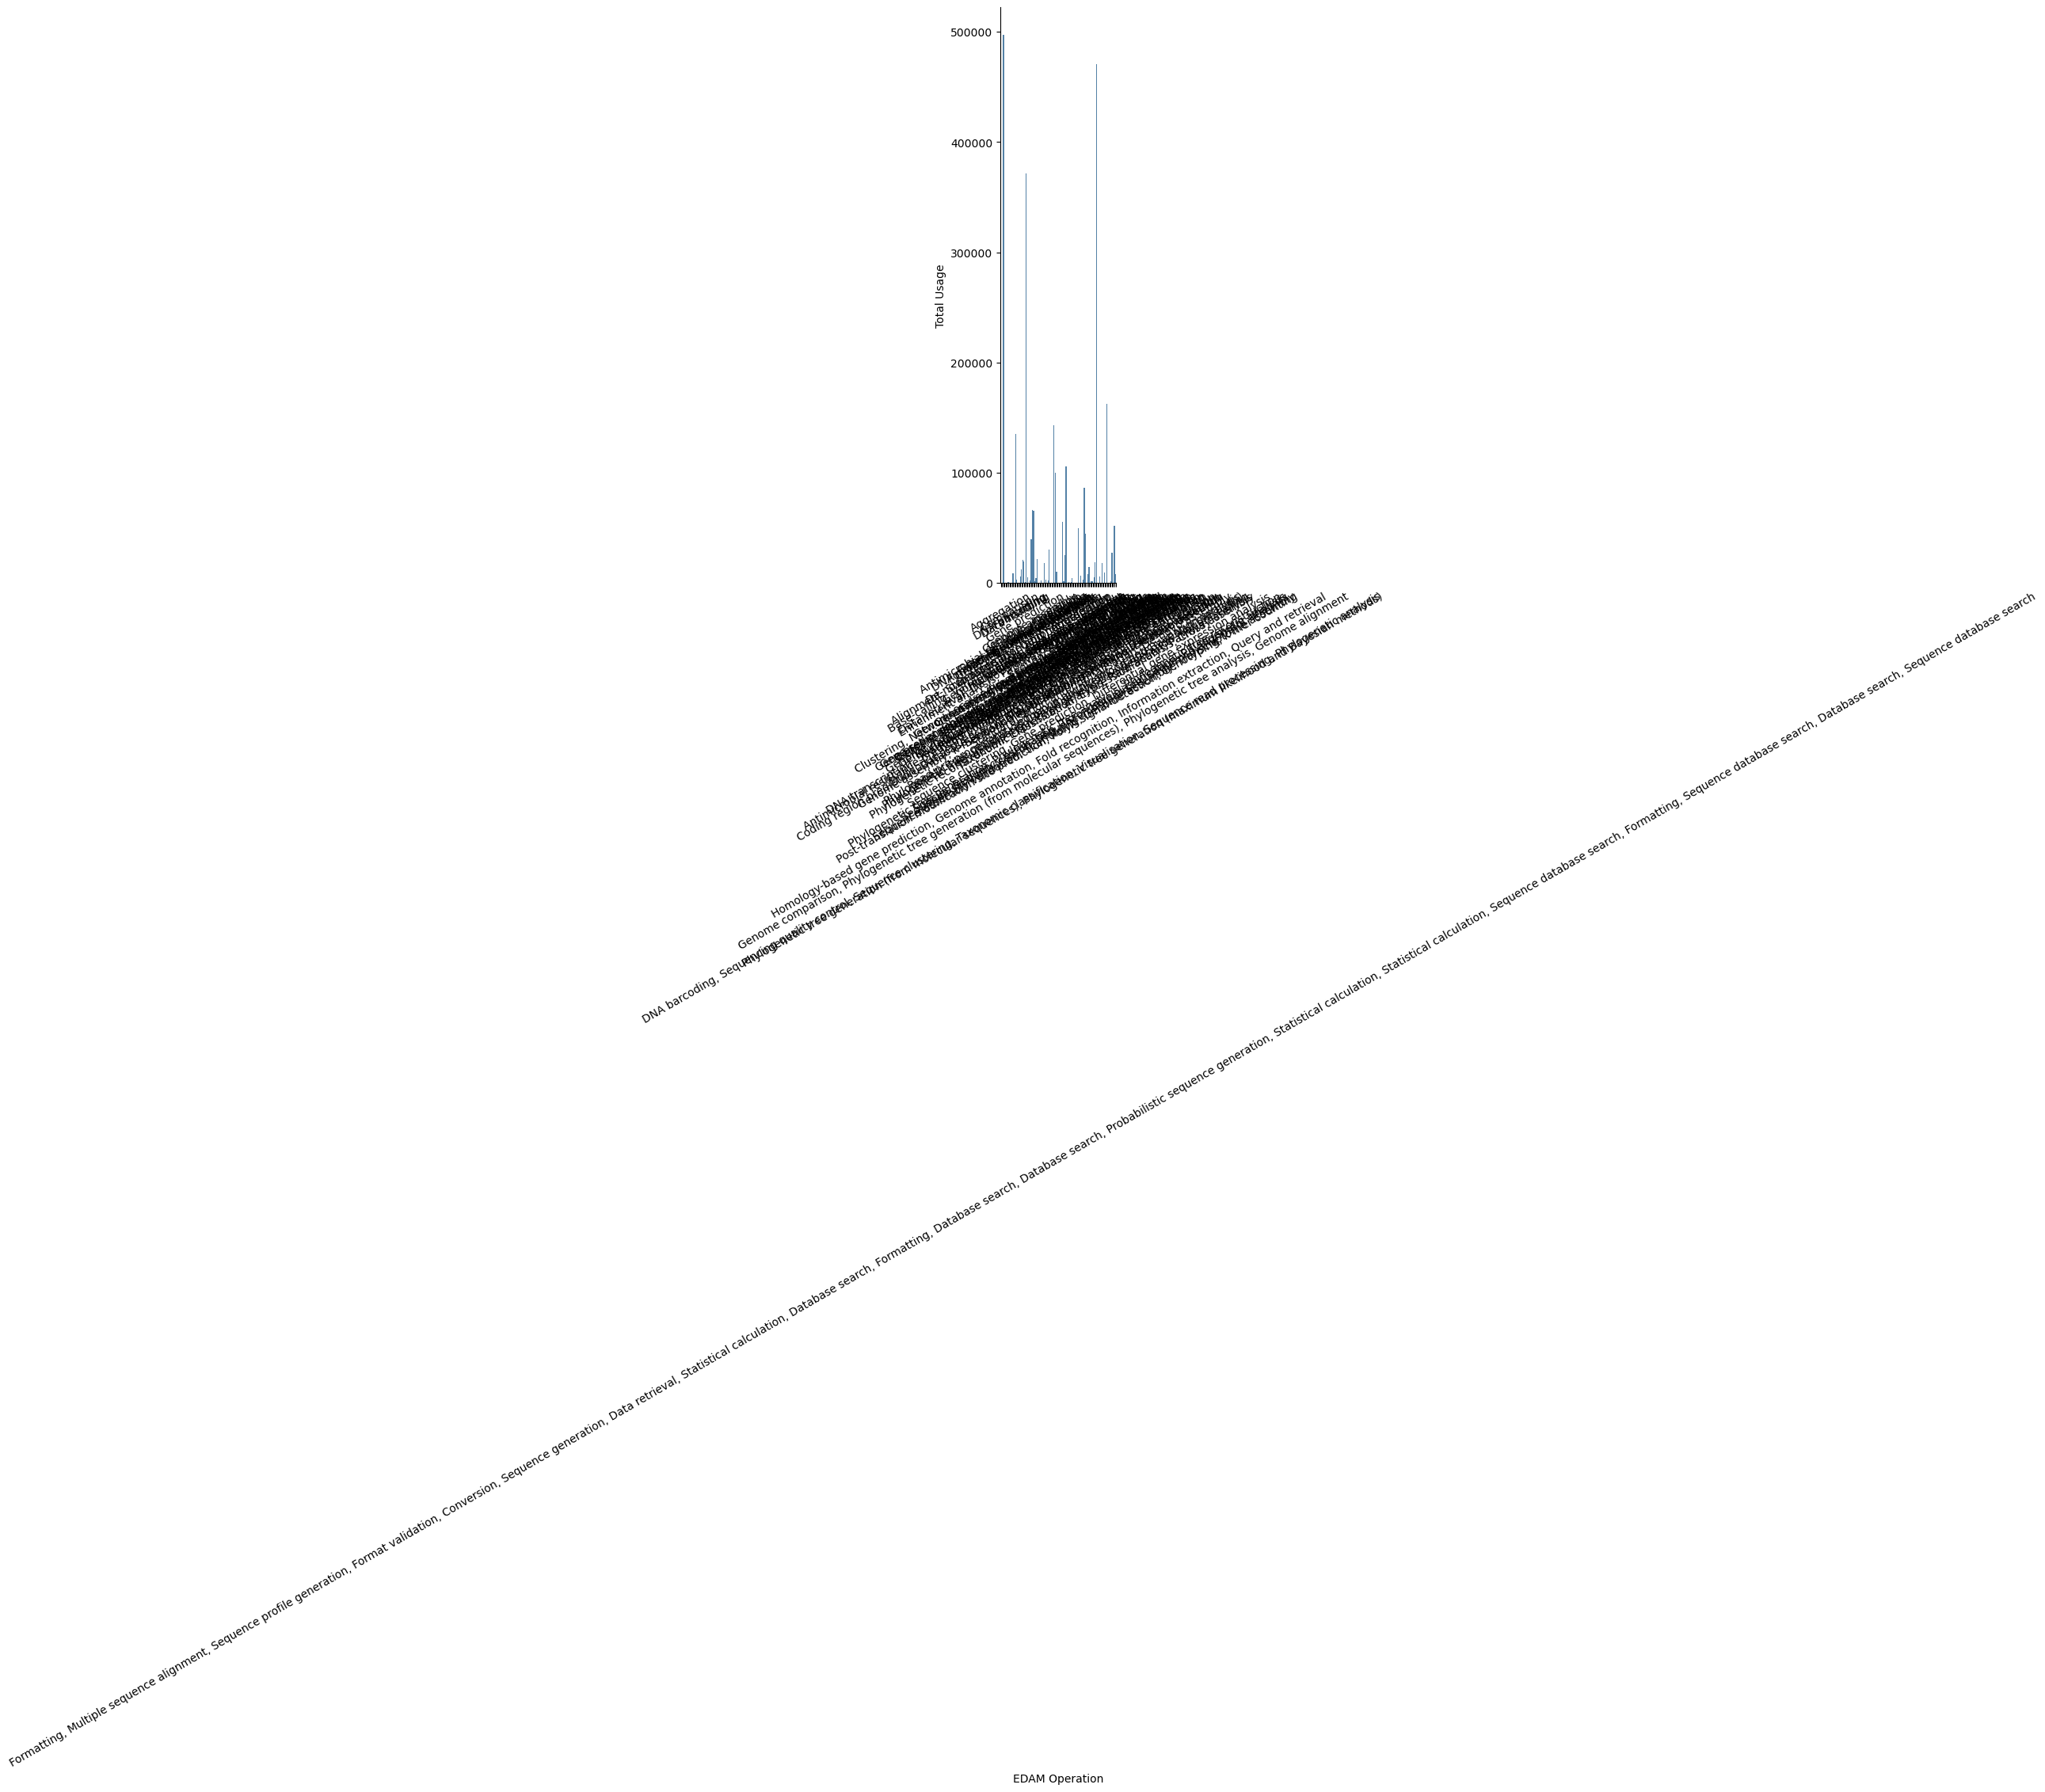

In [16]:
import seaborn as sns
ax = sns.catplot(data=usage_edam_operations_db, kind="bar",x="EDAM operation", y="Total tool usage (usegalaxy.eu)", height=8, aspect=2, color='steelblue')
ax.set_ylabels("Total Usage")
ax.set_xlabels("EDAM Operation")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(os.path.join(outpath, "total_usage_per_edam_operation.svg"))
plt.savefig(os.path.join(outpath, "total_usage_per_edam_operation.png"))
plt.show()

In [17]:
usage_edam_topics_db = tools2_db.groupby('EDAM topic')['Total tool usage (usegalaxy.eu)'].sum()
usage_edam_topics_db = usage_edam_topics_db.reset_index()
usage_edam_topics_db

,EDAM topic,Total tool usage (usegalaxy.eu)
0,Bioinformatics,0.0
1,"Computer science, RNA-Seq, Transcriptomics, Sm...",774.0
2,"DNA, DNA polymorphism, Genetics",0.0
3,"DNA, Genomics, Mapping",12225.0
4,Data quality management,0.0
...,...,...
87,"Whole genome sequencing, Genotype and phenotyp...",0.0
88,"Whole genome sequencing, Mapping, Sequence ass...",3164.0
89,"Whole genome sequencing, Sequence assembly, Ma...",22.0
90,"Whole genome sequencing, Sequence assembly, Pl...",21353.0


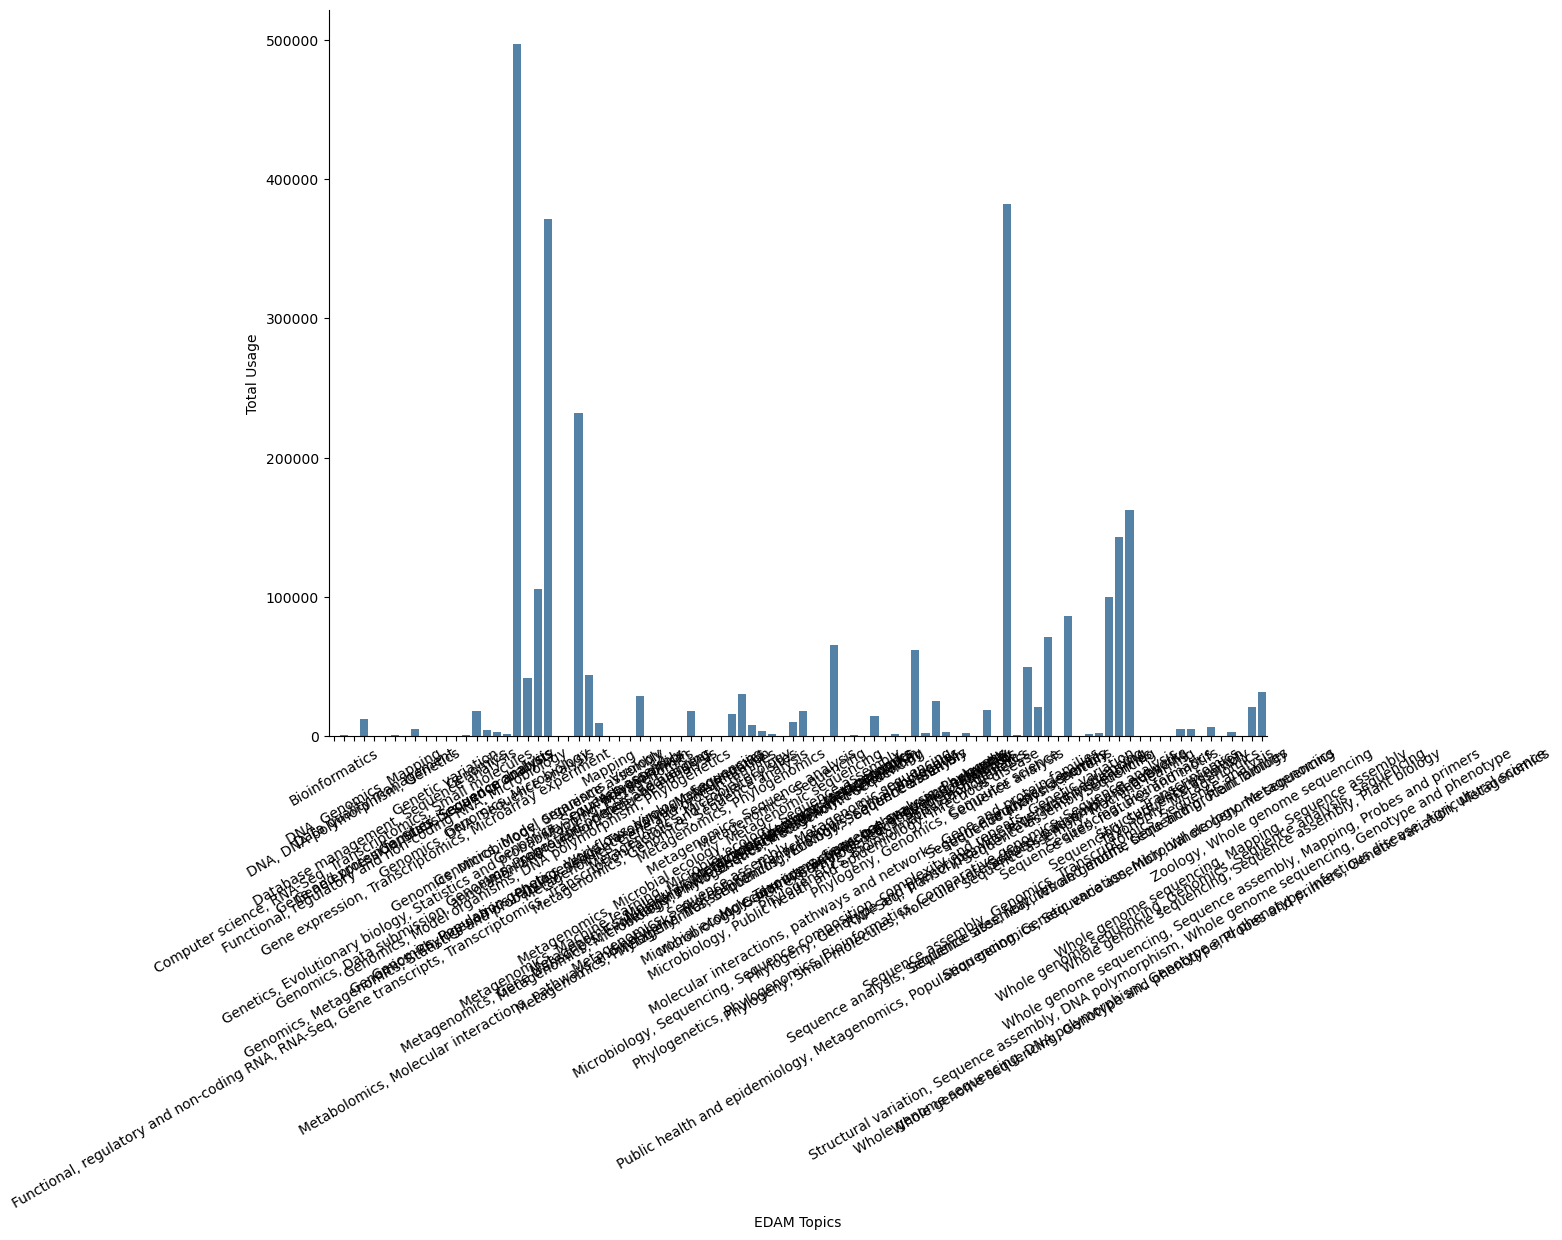

In [18]:
ax = sns.catplot(data=usage_edam_topics_db, kind="bar",x="EDAM topic", y="Total tool usage (usegalaxy.eu)", height=8, aspect=2, color='steelblue')
ax.set_ylabels("Total Usage")
ax.set_xlabels("EDAM Topics")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(os.path.join(outpath, "total_usage_per_edam_topics.svg"))
plt.savefig(os.path.join(outpath, "total_usage_per_edam_topics.png"))
plt.show()

In [19]:
users_edam_operations_db = tools2_db.groupby('EDAM operation')['No. of tool users (2022-2023) (usegalaxy.eu)'].sum()
users_edam_operations_db = users_edam_operations_db.reset_index()
users_edam_operations_db

,EDAM operation,No. of tool users (2022-2023) (usegalaxy.eu)
0,Aggregation,0.0
1,"Alignment, Standardisation and normalisation",12.0
2,Antimicrobial resistance prediction,1764.0
3,"Antimicrobial resistance prediction, Variant c...",0.0
4,"Base-calling, Variant calling, Sequence assembly",0.0
...,...,...
91,Variant pattern analysis,12.0
92,Visualisation,1801.0
93,"Visualisation, Aggregation",0.0
94,"Visualisation, Sequence assembly validation",3567.0


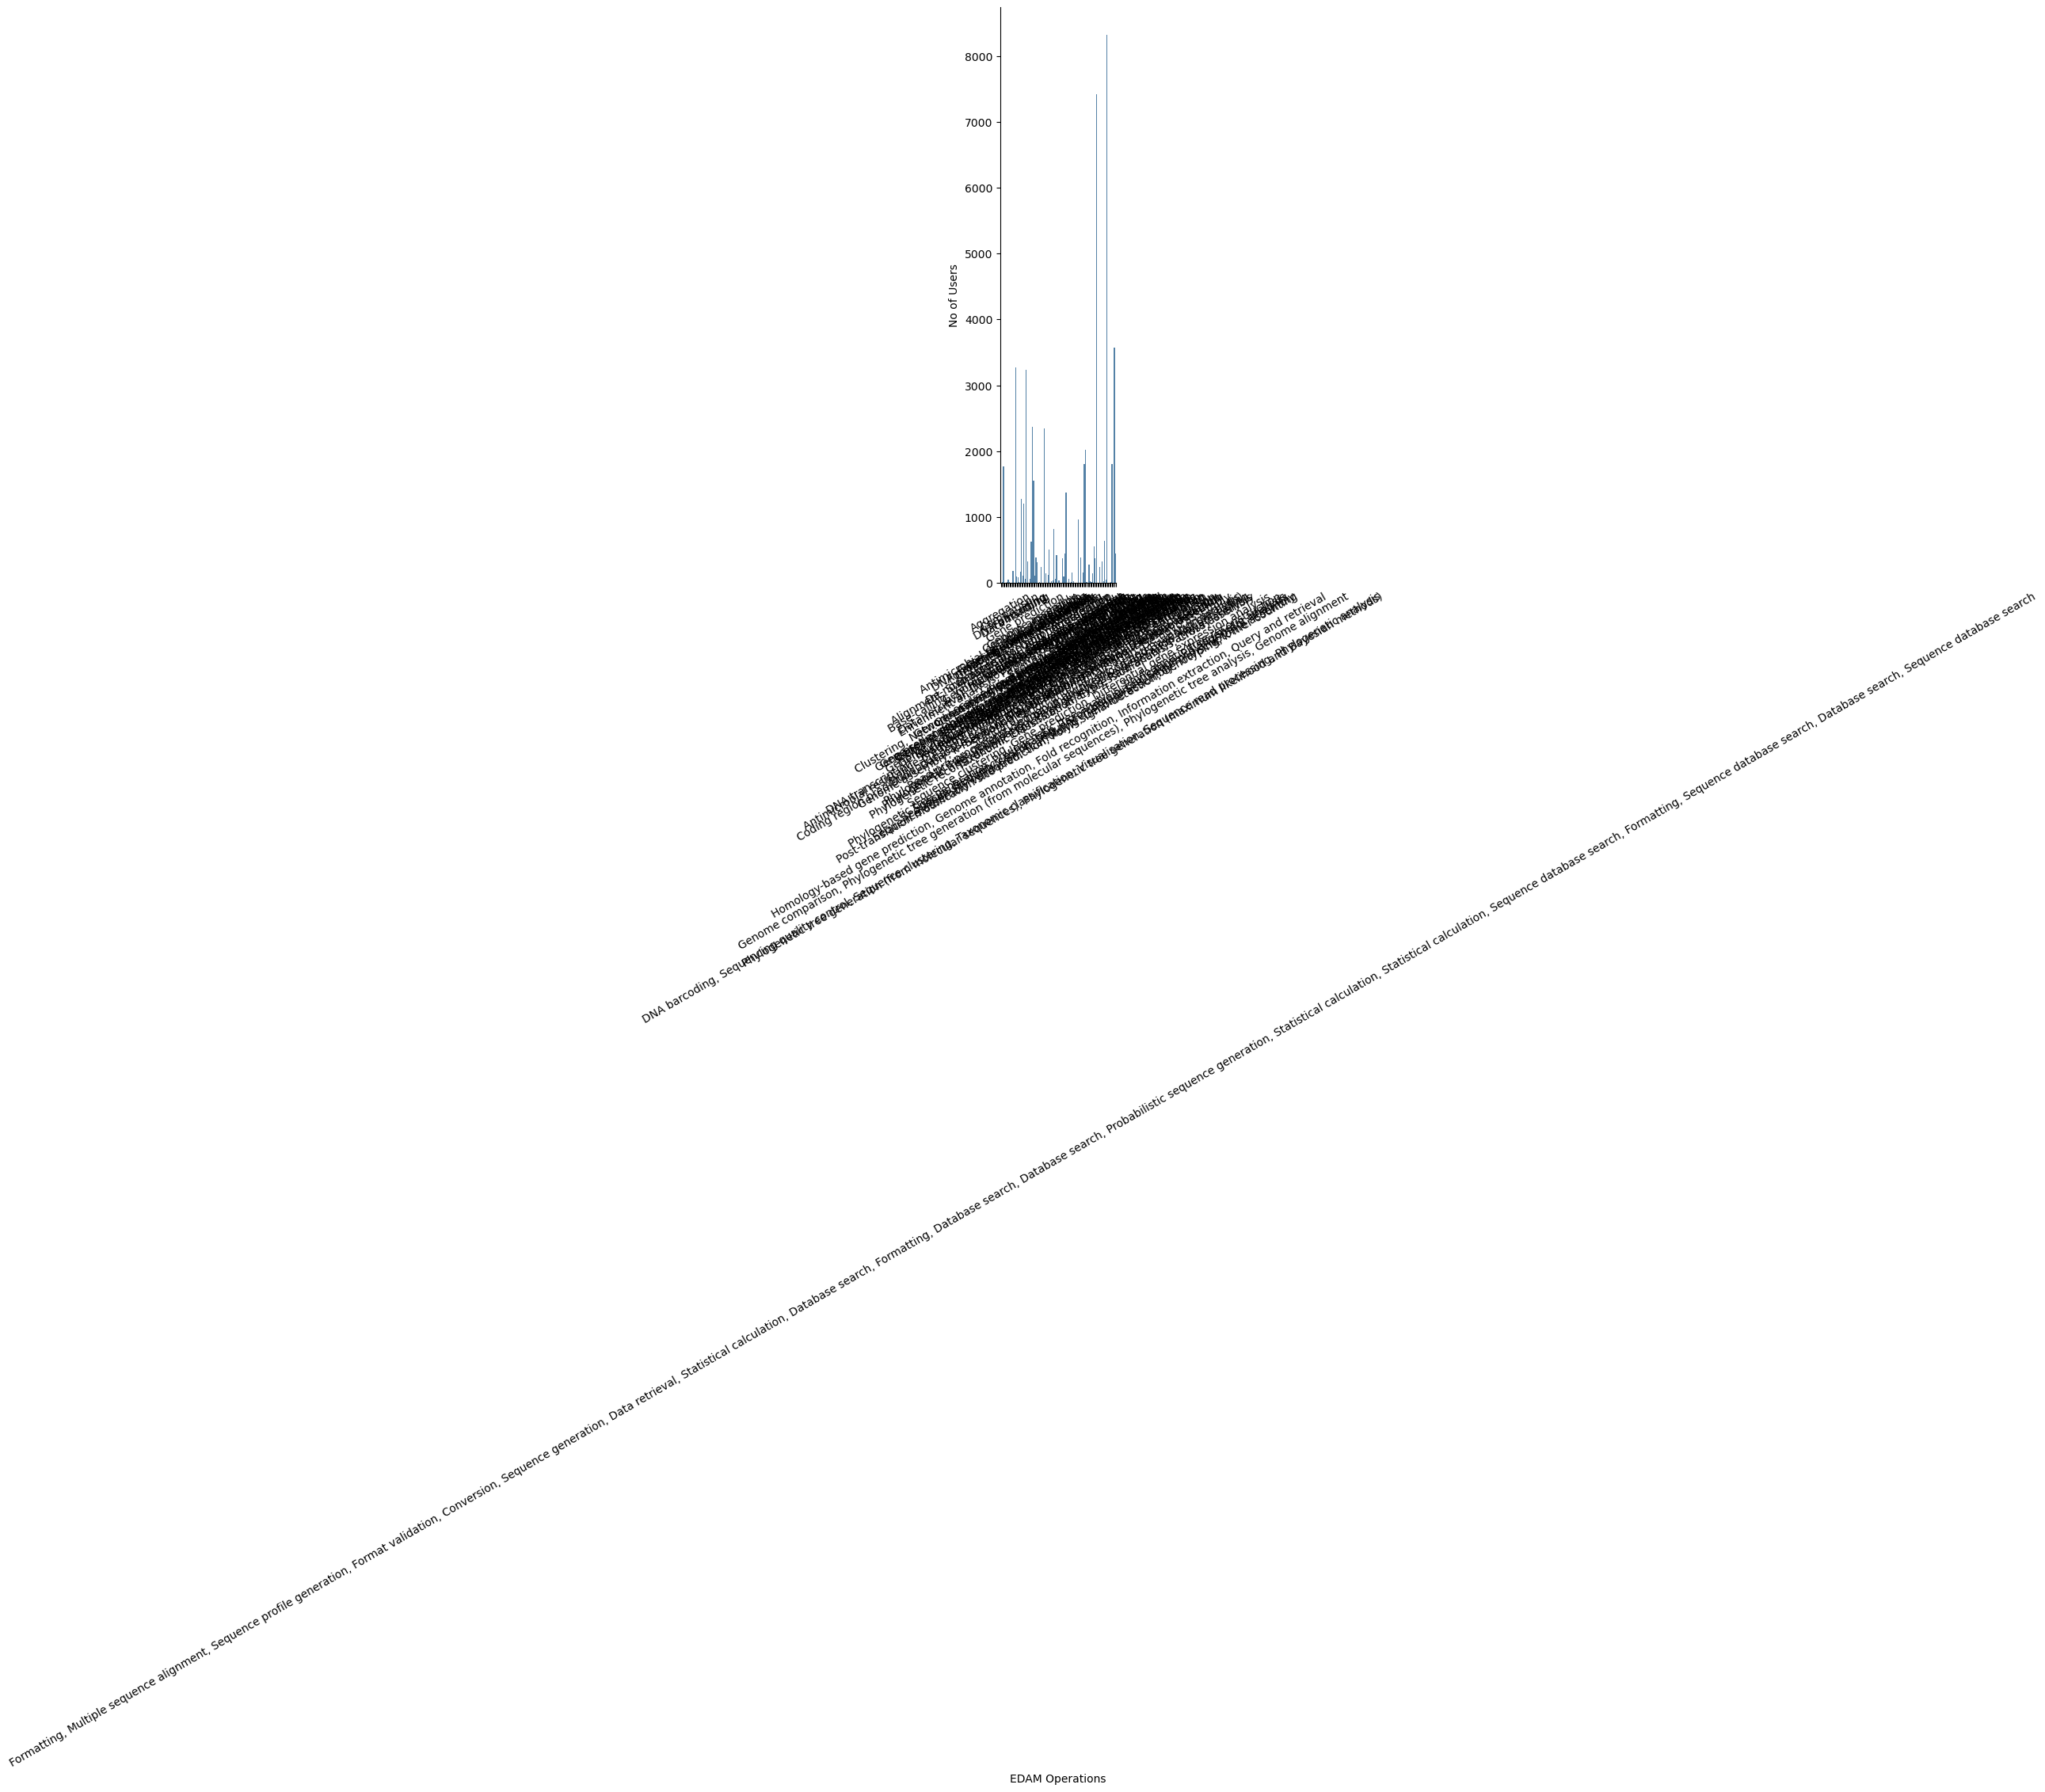

In [20]:
ax = sns.catplot(data=users_edam_operations_db, kind="bar",x="EDAM operation", y="No. of tool users (2022-2023) (usegalaxy.eu)", height=8, aspect=2, color='steelblue')
ax.set_ylabels("No of Users")
ax.set_xlabels("EDAM Operations")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_operations.svg"))
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_operations.png"))
plt.show()

In [21]:
users_edam_topics_db = tools2_db.groupby('EDAM topic')['No. of tool users (2022-2023) (usegalaxy.eu)'].sum()
users_edam_topics_db = users_edam_topics_db.reset_index()
users_edam_topics_db

,EDAM topic,No. of tool users (2022-2023) (usegalaxy.eu)
0,Bioinformatics,0.0
1,"Computer science, RNA-Seq, Transcriptomics, Sm...",53.0
2,"DNA, DNA polymorphism, Genetics",0.0
3,"DNA, Genomics, Mapping",656.0
4,Data quality management,0.0
...,...,...
87,"Whole genome sequencing, Genotype and phenotyp...",0.0
88,"Whole genome sequencing, Mapping, Sequence ass...",94.0
89,"Whole genome sequencing, Sequence assembly, Ma...",8.0
90,"Whole genome sequencing, Sequence assembly, Pl...",309.0


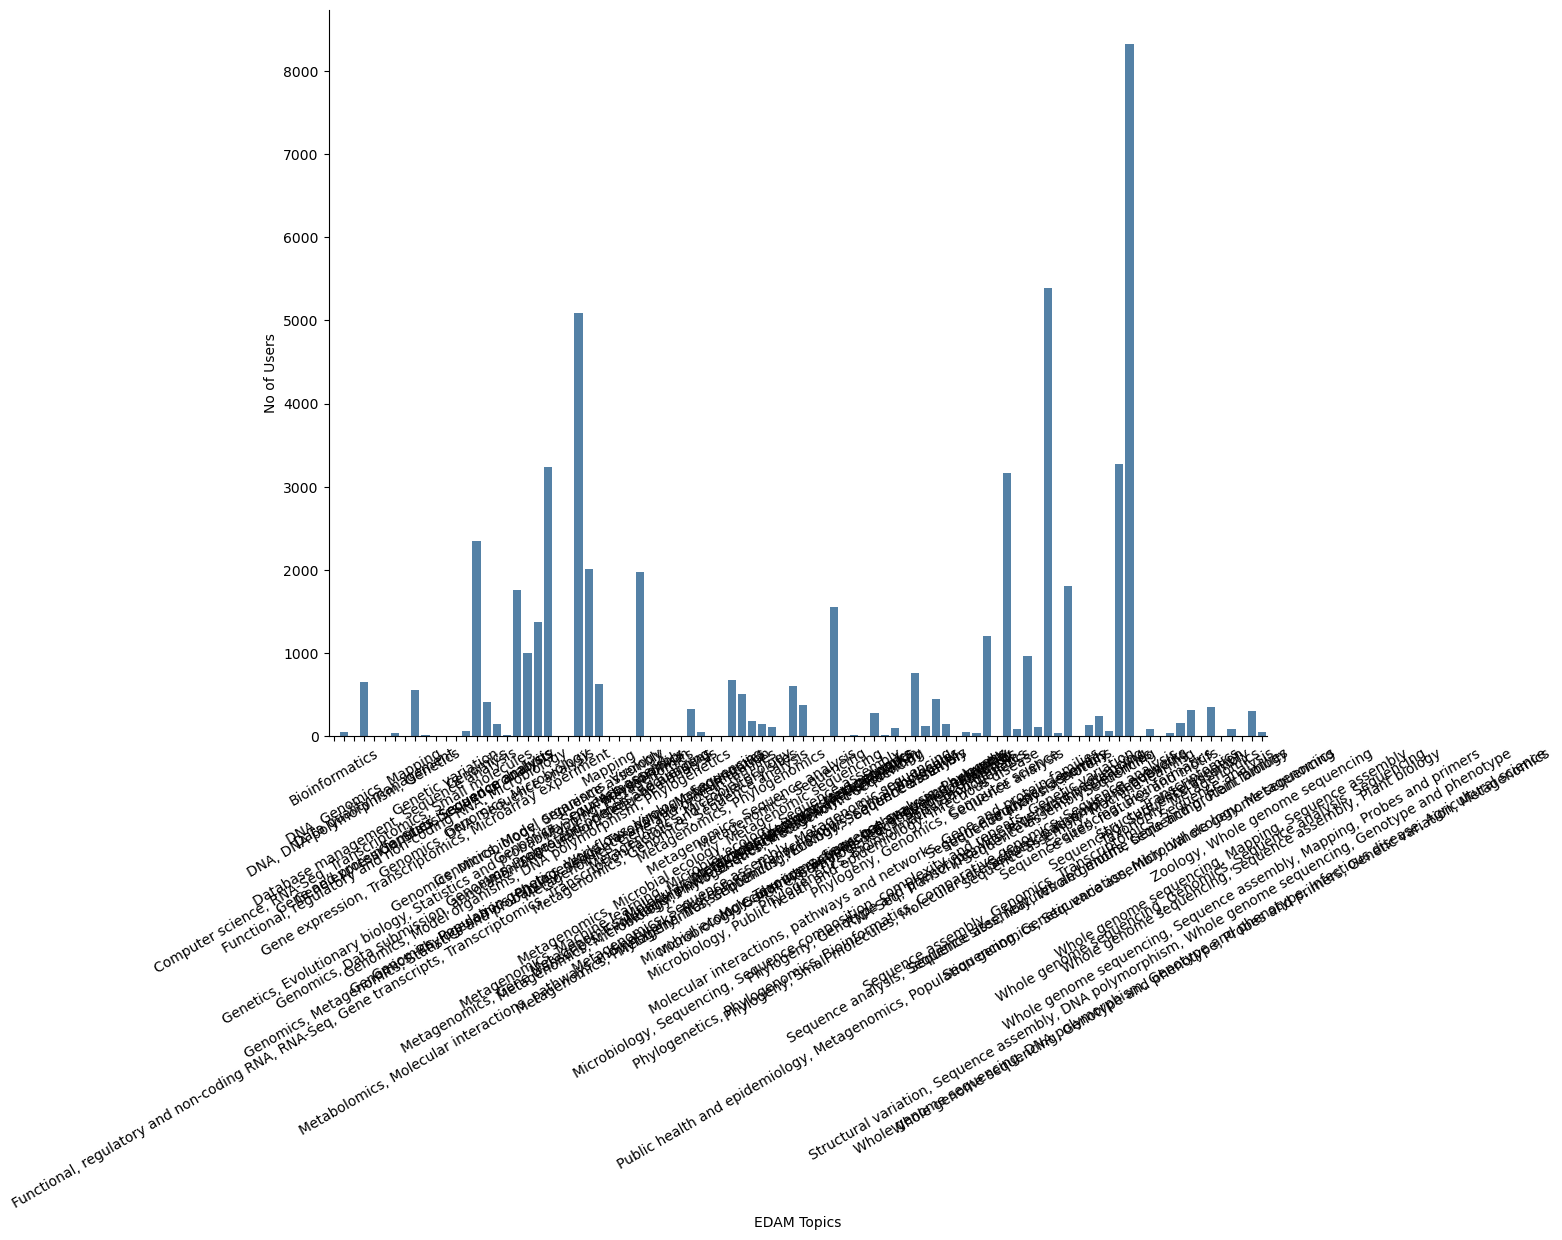

In [22]:
ax = sns.catplot(data=users_edam_topics_db, kind="bar",x="EDAM topic", y="No. of tool users (2022-2023) (usegalaxy.eu)", height=8, aspect=2, color='steelblue')
ax.set_ylabels("No of Users")
ax.set_xlabels("EDAM Topics")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_topics.svg"))
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_topics.png"))
plt.show()

In [23]:
tool_count_edam_operations_db = tools2_db.groupby('EDAM operation')['Galaxy tool ids'].count()
tool_count_edam_operations_db = tool_count_edam_operations_db = tool_count_edam_operations_db.reset_index()
tool_count_edam_operations_db

,EDAM operation,Galaxy tool ids
0,Aggregation,1
1,"Alignment, Standardisation and normalisation",1
2,Antimicrobial resistance prediction,2
3,"Antimicrobial resistance prediction, Variant c...",1
4,"Base-calling, Variant calling, Sequence assembly",1
...,...,...
91,Variant pattern analysis,1
92,Visualisation,1
93,"Visualisation, Aggregation",1
94,"Visualisation, Sequence assembly validation",1


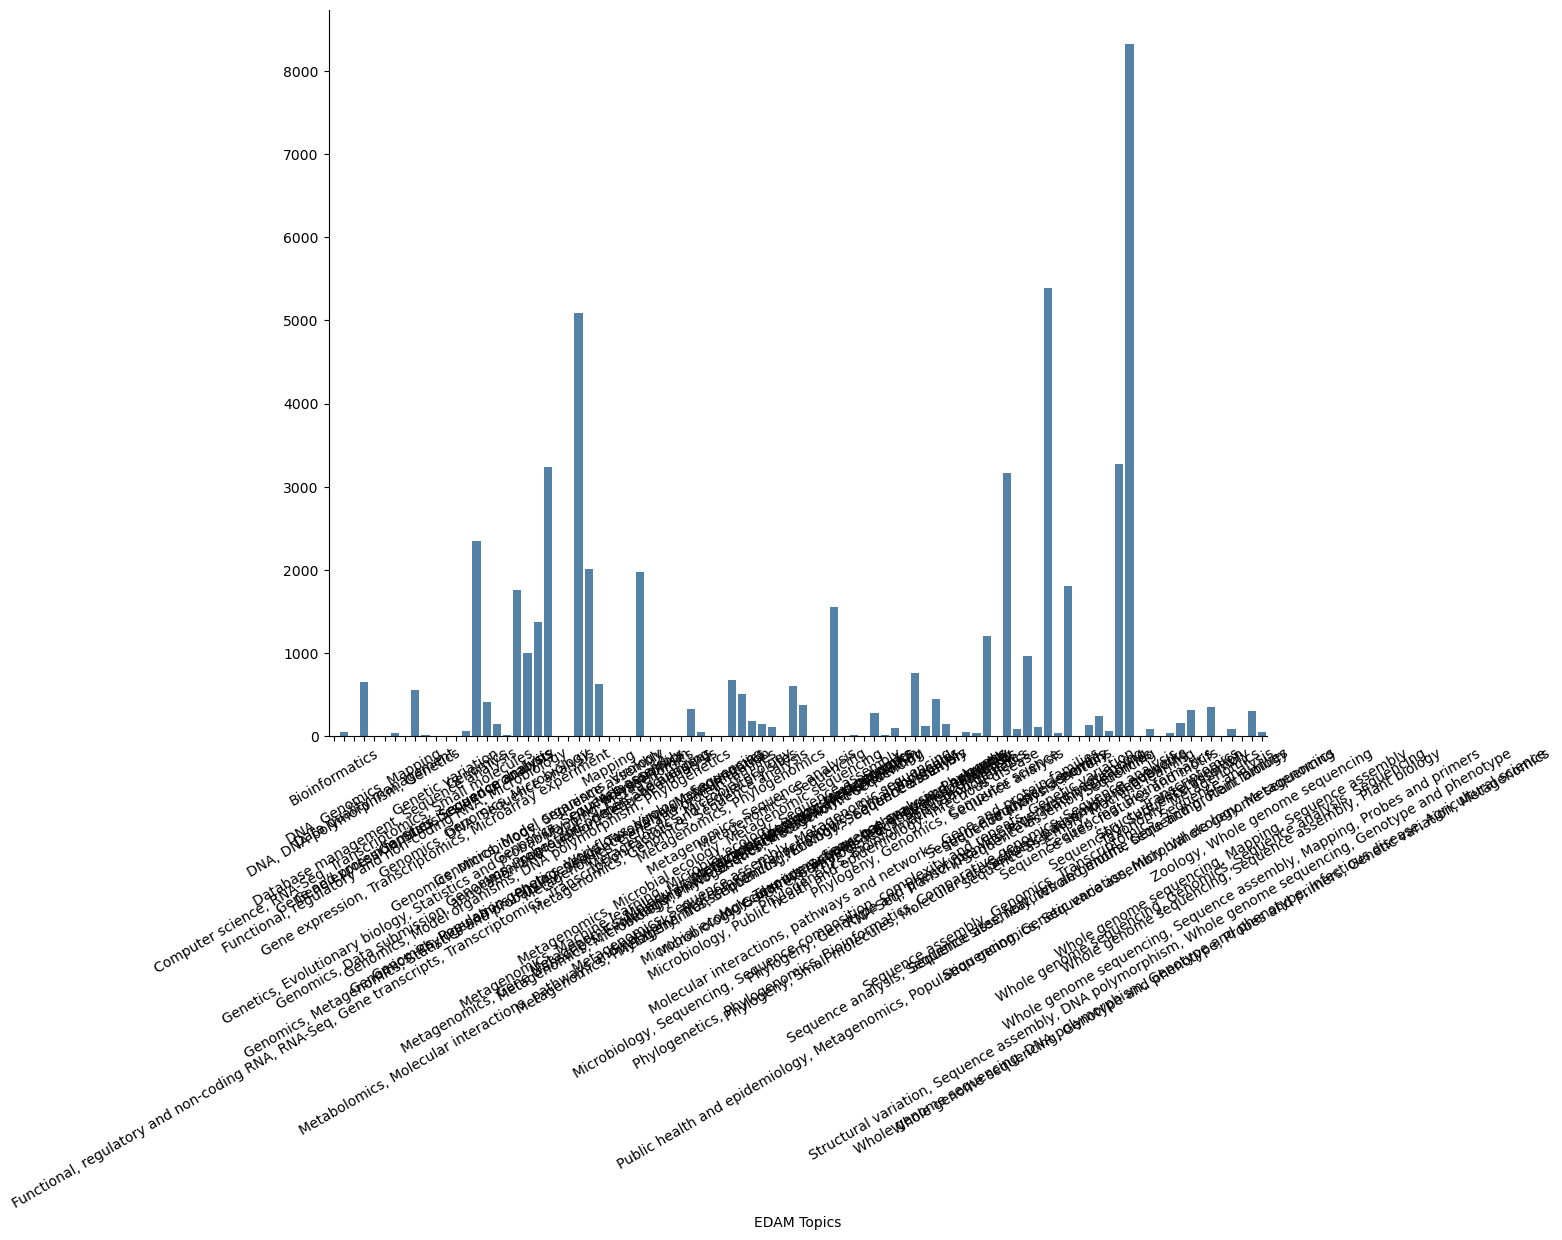

In [24]:
ax = sns.catplot(data=users_edam_topics_db, kind="bar",x="EDAM topic", y="No. of tool users (2022-2023) (usegalaxy.eu)", height=8, aspect=2, color='steelblue')
ax.set_ylabels("")
ax.set_xlabels("EDAM Topics")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_topics.svg"))
plt.savefig(os.path.join(outpath, "no_of_users_per_edam_topics.png"))
plt.show()

## old versions of trials to update EDAM operation column


In [ ]:
import pandas as pd
from owlready2 import get_ontology

# Load the EDAM ontology
edam_ontology = get_ontology('https://edamontology.org/EDAM_1.25.owl').load()

# Function to get EDAM terms based on labels, exact synonyms, and narrow synonyms
def get_edam_terms(ontology, values):
    edam_terms = []

    for value in values:
        # Strip leading and trailing spaces from the value
        value = value.strip()

        term = ontology.search_one(label=value)
        if term:
            edam_terms.append(term)
            print(f"Retrieved term for '{value}' as label: {term}")
        else:
            # If label search fails, try finding the term as hasExactSynonym or hasNarrowSynonym
            term = ontology.search_one(hasExactSynonym=value) or ontology.search_one(hasNarrowSynonym=value)
            if term:
                edam_terms.append(term)
                print(f"Retrieved term for '{value}' as synonym: {term}")
            else:
                print(f"Retrieved term for '{value}': None")

    return edam_terms

# Function to process a DataFrame and filter based on EDAM ontology
def process_dataframe(input_df):
    # Copy the input DataFrame to avoid modifying the original
    df = input_df.copy()

    # Add a new column to store the label of the lowest term for each row
    df['Lowest Term'] = ""

    # Iterate over each row and process the values in each row
    for index, row in df.iterrows():
        # Extract values from the row
        values = row.iloc[1:-1].tolist()  # Exclude 'Galaxy tool ids' and 'Lowest Term'

        # Strip leading and trailing spaces from the values
        values = [value.strip() if pd.notna(value) else value for value in values]

        # Filter out empty values
        values = [value for value in values if pd.notna(value)]

        # Get the EDAM terms for each value
        edam_terms = []
        for value in values:
            try:
                terms = get_edam_terms(edam_ontology, [value])
                print(f"Retrieved terms for '{value}': {terms}")
                edam_terms.extend(terms)
            except AttributeError as e:
                # Handle the case when 'depth' property is not defined
                print(f"Error handling term '{value}': {e}")
                continue
            except Exception as e:
                # Handle other exceptions, e.g., if the term is not found
                print(f"Error retrieving terms for '{value}': {e}")

        # If there are terms found, print them
        if edam_terms:
            print(f"Found terms: {edam_terms}")

        # Find the lowest term in the EDAM ontology hierarchy
        lowest_term = None
        for term in edam_terms:
            try:
                if lowest_term is None or max(ancestor.depth for ancestor in term.ancestors()) > max(ancestor.depth for ancestor in lowest_term.ancestors()):
                    lowest_term = term
            except AttributeError as e:
                # Handle the case when 'depth' property is not defined
                print(f"Error handling term '{term}': {e}")
                continue
            except Exception as e:
                # Handle other exceptions
                print(f"Error handling term '{term}': {e}")

        # If a lowest term is found, update the 'Lowest Term' column with the label
        if lowest_term:
            df.at[index, 'Lowest Term'] = lowest_term.label[0] if lowest_term.label else str(lowest_term)[5:]

    # Filter the DataFrame to keep only the relevant columns
    result_df = df[['Galaxy tool ids', 'Lowest Term'] + list(df.iloc[:, 1:-1])]

    return result_df

# Example usage with a DataFrame
# Replace this with your actual DataFrame
example_df = pd.DataFrame({
    'Galaxy tool ids': ['tool1', 'tool2', 'tool3'],
    'SubColumn0': ['Differential protein expression profiling', 'Sequence analysis', 'Data retrieval'],
    'SubColumn1': [' Gene expression profiling ', '  Phylogenetic tree analysis  ', ' Service invocation ']
})

# Process the DataFrame
result_df = process_dataframe(example_df)

# Display the processed DataFrame
result_df.to_csv('filteredtoolsEDAMoperations.csv', index=False)

print(result_df)


In [81]:
from owlready2 import get_ontology
import copy

edam_ontology = get_ontology('https://edamontology.org/EDAM_1.25.owl').load()

terms = ["Sequence comparison", "Functional clustering","Sequence clustering","Dot plot plotting"]

#convert labels to class
classes = [edam_ontology.search_one(label=term) for term in terms]
check_classes = copy.copy(classes)

new_classes = []
for cla in classes:

    # get all subclasses
    subclasses = list(cla.subclasses())

    #check if any of the other classes is a subclass
    include_class = True
    for subcla in subclasses:
        for cla2 in check_classes:
            if subcla == cla2:
                include_class = False

    # only keep the class if it is not a parent class
    if include_class:
        new_classes.append(cla)

#convert back to terms
new_terms = [cla.label[0] for cla in new_classes]
new_terms


['Functional clustering', 'Dot plot plotting']